In [1]:
from matplotlib import pyplot as plt
import networkx as nx
import random
import numpy as np
import scipy
import itertools
import scipy


In [ ]:
'''
Class: MSocialDynamicsSimulation

Attributes:
[int]network_size: the size of the network to be simulated (i.e number of nodes)
[float]max_alpha: max value that alpha can have. Default: 0.25
[float]alpha: rate at which nodes converge to the same opinion as their neighbors. 
[float]beta: rate at which edge weights change between nodes given their difference in opinions. Default = 0.3
[float]gamma: represents the pickness of the nodes, thus influencing the edge weight. Default = 4
[int]step: how many steps the simulation has run.
[list]ch: holds all charisma values assigned to the nodes
[list]st: holds all stubbornness values assigned to the nodes
[dict]layout: dictionary of positions by node.
[Watts-Strogatz graph object]graph:the network is represented given the type of graph chosen. In this case
                                   we use a Watts-Strogatz graph.
(Source: https://networkx.github.io/documentation/networkx-1.9)

Methods:
__init__(self, network_size=50, max_alpha=0.25, beta=0.3, gamma=4): Initializes fixed parameters of the simulation
Returns: N/A

observe(self): Draws the current state of the network
Returns: N/A

initialize(self): Initializes the simulation by initializing the graph and assigning state value to the nodes.
Returns: N/A

connectNodes(self,node): Connect two nodes based on their "mutual friend" connection. If the chosen node is 
                         already connected to all the nodes connected to its neighbors, then no connection is made.
Returns: boolean

update(self): Updates the state of the network-> the nodes' opinions and edges' weights.
Returns: N/A


'''
class MSocialDynamicsSimulation():

    def __init__(self, network_size=50, max_alpha=0.05, beta=0.3, gamma=4):
        self.network_size = network_size
        self.max_alpha = max_alpha
        self.alpha = random.uniform(max_alpha/2, max_alpha)
        self.beta = beta
        self.gamma = gamma

    def observe(self):
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        plt.clf()
        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            node_color=[self.graph.nodes[i]['opinion'] for i in self.graph.nodes],
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            alpha=0.7, vmin=0, vmax=1)
        plt.title('Step: ' + str(self.step))
    
    def initialize(self):
        # Initialize variables related to the simulation data
        self.ch = list()
        self.st = list()
        self.step = 0
        self.graph = nx.watts_strogatz_graph(self.network_size, 2, 0.5)
        # The max value that epsilon can take to ensure that the opinion differences
        # stay between 0 and 1. Epsilon is the difference between one node's charisma and
        # the other node's stubbornness
        max_epsilon = abs(self.alpha - self.max_alpha)
        # sets nodes' attribute values
        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = 0.5
        for node in self.graph.nodes:
            self.graph.nodes[node]['politics'] = random.randint(0, 1)
            self.graph.nodes[node]['religion'] = random.randint(0, 1)
            self.graph.nodes[node]['opinion'] = (self.graph.nodes[node]['politics'] + self.graph.nodes[node]['religion'])/2
            self.graph.nodes[node]['charisma'] = random.uniform(0,max_epsilon)
            self.graph.nodes[node]['stubbornness'] = random.uniform(0, max_epsilon)
            self.ch.append(self.graph.nodes[node]['charisma'])
            self.st.append(self.graph.nodes[node]['stubbornness'])
        # Set initial visual layout
        self.layout = nx.spring_layout(self.graph)  
        
    def connectNodes(self,node):
        
        neighborsList = list(self.graph.neighbors(node[0]))
        picked = False

        while picked == False and len(neighborsList) > 0:
            neighbor = random.sample(neighborsList, 1)
            neighborsList.remove(neighbor[0])

            for n in list(self.graph.neighbors(neighbor[0])):
                if [node[0],n] not in self.graph.edges:
                    self.graph.add_edge(node[0], n, weight=0.5)
                    picked = True
                    break
            
        return picked
    
    def update(self):
        # With a 1% chance, creates a new edge with weight 0.5 between two unconnected nodes
        if random.uniform(0, 1) < 0.01:
            nodes = list(self.graph.nodes)
            picked = False
            node = random.sample(nodes, 1)
            nodes.remove(node[0])
            neighbors = list(self.graph.neighbors(node[0]))
            
            # if the node has neighbors, connect it to another node
            # connected to one of its neighbors
            if len(neighbors) > 0:
                picked = self.connectNodes(node)
            # if there is no node connected to its neighbors available or the
            # chosen node has no neighbors, then randomly connect it to another
            # node in the network
            if picked == False:
                while True:
                    new_node = (random.sample(nodes, 1))
                    new_edge = [node[0],new_node[0]]
                    if new_edge not in self.graph.edges:
                        self.graph.add_edge(node[0],new_node[0], weight=0.5)
                        break        
        else:
            # Select a random topic
            topic = random.sample(['politics', 'religion'], 1)[0]
            
            # Select a random edge... 
            edge = random.choice(list(self.graph.edges))
            
            # ...and update node opinions and edge weight, taking into consideration
            # the other node's charisma and the selected node's stubbornness
            weight = self.graph.edges[edge]['weight']
            opinions = [self.graph.nodes[n][topic] for n in edge]
            for i in [0, 1]:
                self.graph.nodes[edge[i]][topic] = (
                    opinions[i] + (self.graph.nodes[edge[1-i]]['charisma'] - self.graph.nodes[edge[i]]['stubbornness'] + self.alpha) * weight * (opinions[1-i] - opinions[i]))
            self.graph.edges[edge]['weight'] = (
                weight +
                self.beta * weight * (1-weight) *
                (1 - self.gamma * abs(opinions[0] - opinions[1])))

            # Update weights based on their level of connection
            if self.graph.edges[edge]['weight'] >= 0.8 and self.graph.edges[edge]['weight'] <= 0.9:
                self.graph.edges[edge]['weight'] += self.graph.edges[edge]['weight']*0.1
            elif self.graph.edges[edge]['weight'] <= 0.2 and self.graph.edges[edge]['weight'] >= 0.06:
                self.graph.edges[edge]['weight'] -= self.graph.edges[edge]['weight']*0.2
            
            # Remove very weak connections
            if self.graph.edges[edge]['weight'] < 0.05:
                self.graph.remove_edge(*edge)
            
            # Update opinion value
            for n in edge:
                self.graph.nodes[n]['opinion'] = (self.graph.nodes[n]['politics'] + self.graph.nodes[n]['religion'])/2
        self.step += 1
        
# Run simulation
sim = MSocialDynamicsSimulation()
sim.initialize()
plt.figure()
sim.observe()
for i in range(20):
    for i in range(1000):
        sim.update()
    plt.figure()
    sim.observe()


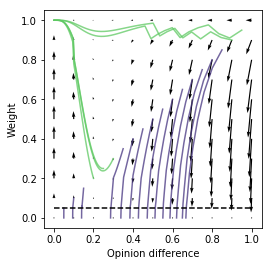

In [3]:
'''
The goal for this block of code is to simulate a very small scale network 
with initial values nicely spread out accross the graph so we can better
visualize the model's behavior given different initial points. 
The result is a vector field alongside functions lines simulating how te variables will behave 
given an initial edge(taking into consideration its weight and the difference in opinion
between the two nodes in it). 
'''

# initialized properties to be used in the plots below.
# The parameters are taken from the simulation above.
alpha = sim.alpha
beta = sim.beta
gamma = sim.gamma
ch = np.mean(sim.ch)
st = np.mean(sim.st)
# initializes color map
cmap = plt.cm.viridis

# Builds a list to simulate the behavior of the opinion
# difference and weights with only 10 points evenly distributted
# from 0 to 1. This manipulation is needed for a better visualization of the
# model behavior regarding these properties.
owList = list()
for i in np.arange(0, 1,0.05):
    owList.append([i,i])

# For every "edge", simulate its behavior across 100 steps and adds 
# it to the plot
for opinion, weight in owList:

    opinion_weight = [[opinion, 0, weight]]
    
    for i in range(100):
        deltaOpinion = (ch-st+alpha) * opinion_weight[-1][2] * (opinion_weight[-1][1] - opinion_weight[-1][0])
        deltaWeight = (beta * opinion_weight[-1][2] * (1-opinion_weight[-1][2]) * (1-gamma*abs(opinion_weight[-1][1] - opinion_weight[-1][0])))
        
        newWeight = opinion_weight[-1][2] + deltaWeight 
        if newWeight >= 0.8 and newWeight <= 0.9:
            newWeight += newWeight*0.1
        elif newWeight <= 0.2 and newWeight >= 0.06:
            newWeight -= newWeight*0.2
        
        if newWeight < 0.05:
            newWeight = 0
            

        opinion_weight.append([abs(opinion_weight[-1][0] + deltaOpinion ), abs(opinion_weight[-1][1] - deltaOpinion), newWeight])
        
        # builds plot line of the behavior 
    plt.plot(
        [row[0] - row[1] for row in opinion_weight],
        [row[2] for row in opinion_weight],
        color=(cmap(0.15) if opinion_weight[-1][2] <= 0.05 else cmap(0.75)),
        alpha=0.75)

# Plot vector field
# difference in opinion:
opinion = scipy.linspace(0, 1, 11)
# weights:
weight = scipy.linspace(0, 1, 11) 

# Getting delta opinion and delta weights for the points in the grid to build the vector field plot
opinion_weight_grid = scipy.meshgrid(opinion, weight)
oGrid = -(ch-st+alpha) * opinion_weight_grid[1] * opinion_weight_grid[0]
wGgrid = beta * opinion_weight_grid[1] * (1-opinion_weight_grid[1]) * (1 - gamma * opinion_weight_grid[0])
plt.quiver(opinion_weight_grid[0], opinion_weight_grid[1], oGrid, wGgrid)

# Plot properties
plt.xlabel('Opinion difference')
plt.ylabel('Weight')
# includes a dashed line at 0.05, the cutout point to break a connection between nodes
plt.plot([0, 1], [0.05, 0.05], 'k--')
plt.axis('square')
plt.show()

